# Cálculo de Indicadores Climáticos para Escenarios SSP

Este notebook calcula indicadores climáticos a partir de datos CMIP6 corregidos por bias para preparar el desarrollo de autoencoders. Se basa en los indicadores definidos en `cr2_cnn.ipynb`.

## Objetivos
1. Procesar datos climáticos de escenarios SSP (historical, ssp245, ssp370, ssp585)
2. Calcular indicadores climáticos estándar basados en temperatura y precipitación
3. Generar índices de extremos y sequía
4. Preparar datos estructurados para entrenamiento de autoencoder

## Indicadores a Calcular
- **Temperatura**: tmax_mean, tmin_mean
- **Precipitación total**: prcptot
- **Sequía**: CDD, SPI, MAI, SDII  
- **Extremos**: rx1day, rx5day, r95p, r99p
- **Variabilidad**: PCI, MFI, r10mm

In [3]:
# === LIBRERÍAS Y CONFIGURACIÓN ===
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías para cálculos climáticos
from scipy import stats
from scipy.stats import norm
import dask
dask.config.set({'array.slicing.split_large_chunks': False})

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")

print("🌡️ === CÁLCULO DE INDICADORES CLIMÁTICOS SSP ===")
print(f"🕐 Iniciado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("📦 Librerías cargadas exitosamente")

🌡️ === CÁLCULO DE INDICADORES CLIMÁTICOS SSP ===
🕐 Iniciado: 2025-10-12 01:14:25
📦 Librerías cargadas exitosamente


In [10]:
# === CONFIGURACIÓN DE RUTAS Y PARÁMETROS ===

# Rutas de datos
BASE_DIR = Path("/home/aninotna/magister/tesis/justh2_pipeline")
DATA_DIR = BASE_DIR / 'data' / 'cmip6' / 'bias_corrected_complete' / 'ACCESS-CM2'
OUTPUT_DIR = BASE_DIR / "data" / "cmip6" / "indicators"
REPORTS_DIR = BASE_DIR / "reports"

# Crear directorios si no existen
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Parámetros del Valle de Aconcagua
LAT_MIN, LAT_MAX = -33.27, -32.26
LON_MIN, LON_MAX = -71.89, -70.00

# Variables y escenarios disponibles
VARIABLES = ['tasmin', 'tasmax', 'pr']
SCENARIOS = ['historical', 'ssp245', 'ssp370', 'ssp585']
MODEL = 'ACCESS-CM2'

print(f"📁 Directorio de datos: {DATA_DIR}")
print(f"📁 Directorio de salida: {OUTPUT_DIR}")
print(f"🌍 Región: Valle de Aconcagua")
print(f"   📍 Latitud: {LAT_MIN}° a {LAT_MAX}°")
print(f"   📍 Longitud: {LON_MIN}° a {LON_MAX}°")
print(f"🌡️ Variables: {', '.join(VARIABLES)}")
print(f"🌍 Escenarios: {', '.join(SCENARIOS)}")
print(f"🖥️ Modelo: {MODEL}")

# Verificar existencia de archivos
print("\n📂 === VERIFICACIÓN DE ARCHIVOS ===")
files_found = []
files_missing = []

for var in VARIABLES:
    for scenario in SCENARIOS:
        file_pattern = f"{var}_{MODEL}_{scenario}_*"
        print(f"🔍 Buscando: {file_pattern}")
        path = DATA_DIR / var / scenario
        print(f"   📁 Ruta: {path}")
        files = list(path.glob(file_pattern)) if path.exists() else []

        if files:
            # Tomar el primer archivo encontrado
            file_path = files[0]
            files_found.append({
                'variable': var,
                'scenario': scenario,
                'path': file_path,
                'size_mb': file_path.stat().st_size / (1024*1024)
            })
            print(f"✅ {var} - {scenario}: {file_path.name} ({file_path.stat().st_size / (1024*1024):.1f} MB)")
        else:
            files_missing.append(f"{var} - {scenario}")
            print(f"❌ {var} - {scenario}: No encontrado")

print(f"\n📊 Archivos encontrados: {len(files_found)}")
print(f"❌ Archivos faltantes: {len(files_missing)}")

if files_missing:
    print(f"⚠️ Archivos faltantes: {', '.join(files_missing)}")
    
# Crear DataFrame con archivos encontrados
if files_found:
    df_files = pd.DataFrame(files_found)
    print(f"\n📋 Resumen de archivos disponibles:")
    print(df_files.groupby('variable')['scenario'].apply(list).to_string())
else:
    print("❌ No se encontraron archivos para procesar")

📁 Directorio de datos: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected_complete/ACCESS-CM2
📁 Directorio de salida: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/indicators
🌍 Región: Valle de Aconcagua
   📍 Latitud: -33.27° a -32.26°
   📍 Longitud: -71.89° a -70.0°
🌡️ Variables: tasmin, tasmax, pr
🌍 Escenarios: historical, ssp245, ssp370, ssp585
🖥️ Modelo: ACCESS-CM2

📂 === VERIFICACIÓN DE ARCHIVOS ===
🔍 Buscando: tasmin_ACCESS-CM2_historical_*
   📁 Ruta: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected_complete/ACCESS-CM2/tasmin/historical
✅ tasmin - historical: tasmin_ACCESS-CM2_historical_complete_1850-2014.nc (0.6 MB)
🔍 Buscando: tasmin_ACCESS-CM2_ssp245_*
   📁 Ruta: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/bias_corrected_complete/ACCESS-CM2/tasmin/ssp245
✅ tasmin - ssp245: tasmin_ACCESS-CM2_ssp245_complete_2015-2100.nc (0.3 MB)
🔍 Buscando: tasmin_ACCESS-CM2_ssp370_*
   📁 Ruta: /home/aninotna/magister/tesis/ju

In [19]:
# === FUNCIONES PARA CÁLCULO DE INDICADORES ===

def convert_temperature_units(da, target='celsius'):
    """Convierte unidades de temperatura entre Kelvin y Celsius"""
    if 'units' in da.attrs:
        current_units = da.attrs['units'].lower()
        if 'kelvin' in current_units or 'k' == current_units:
            if target == 'celsius':
                da_converted = da - 273.15
                da_converted.attrs.update(da.attrs)
                da_converted.attrs['units'] = 'celsius'
                return da_converted
    return da

def convert_precipitation_units(da, target='mm_day'):
    """Convierte unidades de precipitación a mm/día"""
    if 'units' in da.attrs:
        current_units = da.attrs['units'].lower()
        if 'kg m-2 s-1' in current_units or 'kg/m2/s' in current_units:
            if target == 'mm_day':
                # kg m-2 s-1 * 86400 s/day = mm/day
                da_converted = da * 86400
                da_converted.attrs.update(da.attrs)
                da_converted.attrs['units'] = 'mm/day'
                return da_converted
    return da

def calcular_cdd(pr, umbral=1.0):
    """
    Calcula Consecutive Dry Days (CDD) - máxima secuencia de días consecutivos secos
    
    Args:
        pr: xarray DataArray de precipitación diaria
        umbral: umbral de precipitación para considerar día seco (mm/día)
    
    Returns:
        xarray DataArray con CDD anual
    """
    # Identificar días secos
    secos = pr < umbral
    
    # Obtener años únicos
    años = pd.to_datetime(pr.time.values).year
    años_unicos = np.unique(años)
    
    # Inicializar array de resultados
    cdd_anual = []
    
    for año in años_unicos:
        # Seleccionar datos del año
        mask_año = años == año
        secos_año = secos.isel(time=mask_año)
        
        # Calcular rachas secas máximas por píxel
        cdd_año = xr.apply_ufunc(
            calcular_racha_maxima,
            secos_año,
            input_core_dims=[['time']],
            output_core_dims=[[]],
            vectorize=True,
            dask='allowed'
        )
        
        cdd_año = cdd_año.assign_coords(year=año)
        cdd_anual.append(cdd_año)
    
    # Concatenar años
    cdd_result = xr.concat(cdd_anual, dim='year')
    cdd_result.attrs['long_name'] = 'Consecutive Dry Days'
    cdd_result.attrs['units'] = 'days'
    
    return cdd_result

def calcular_racha_maxima(secos_1d):
    """Función auxiliar para calcular la racha seca máxima en una serie temporal 1D"""
    if len(secos_1d) == 0 or np.all(np.isnan(secos_1d)):
        return np.nan
    
    # Convertir a enteros (True=1, False=0)
    secos_int = secos_1d.astype(int)
    
    # Encontrar cambios en la secuencia
    cambios = np.diff(np.concatenate(([0], secos_int, [0])))
    
    # Inicios de rachas secas (cambio de 0 a 1)
    inicios = np.where(cambios == 1)[0]
    # Finales de rachas secas (cambio de 1 a 0)  
    finales = np.where(cambios == -1)[0]
    
    if len(inicios) == 0:
        return 0
    
    # Calcular duraciones
    duraciones = finales - inicios
    
    return int(np.max(duraciones))

def calcular_sdii(pr, umbral=1.0):
    """
    Calcula Simple Daily Intensity Index (SDII) - precipitación promedio en días húmedos
    
    Args:
        pr: xarray DataArray de precipitación diaria
        umbral: umbral para considerar día húmedo (mm/día)
    
    Returns:
        xarray DataArray con SDII anual
    """
    # Días húmedos
    dias_humedos = pr.where(pr >= umbral)
    
    # SDII anual = precipitación total / número de días húmedos
    sdii_anual = dias_humedos.groupby('time.year').sum() / dias_humedos.groupby('time.year').count()
    
    sdii_anual.attrs['long_name'] = 'Simple Daily Intensity Index'
    sdii_anual.attrs['units'] = 'mm/day'
    
    return sdii_anual

def calcular_mfi(pr):
    """
    Calcula Monthly Flow Index (MFI) - variabilidad de precipitación mensual
    
    Args:
        pr: xarray DataArray de precipitación diaria
    
    Returns:
        xarray DataArray con MFI anual
    """
    # Precipitación mensual
    pr_mensual = pr.resample(time='1M').sum()
    
    # Por año, calcular max/mean de precipitación mensual
    pr_año = pr_mensual.groupby('time.year')
    mfi = pr_año.max() / pr_año.mean()
    
    mfi.attrs['long_name'] = 'Monthly Flow Index'
    mfi.attrs['units'] = 'dimensionless'
    
    return mfi

def calcular_pci(pr):
    """
    Calcula Precipitation Concentration Index (PCI) - concentración estacional de precipitación
    
    Args:
        pr: xarray DataArray de precipitación diaria
    
    Returns:
        xarray DataArray con PCI anual
    """
    # Precipitación mensual
    pr_mensual = pr.resample(time='1M').sum()
    
    # Agrupar por año y calcular PCI
    pr_año = pr_mensual.groupby('time.year')
    
    # PCI = 100 * sum(Pi^2) / (sum(Pi))^2
    # donde Pi es precipitación del mes i
    pci = 100 * pr_año.apply(lambda x: (x ** 2).sum(dim='time') / (x.sum(dim='time') ** 2))
    
    pci.attrs['long_name'] = 'Precipitation Concentration Index'
    pci.attrs['units'] = 'percent'
    
    return pci

print("🔧 Funciones de cálculo de indicadores definidas:")
print("   ✅ convert_temperature_units")
print("   ✅ convert_precipitation_units")
print("   ✅ calcular_cdd (Consecutive Dry Days)")
print("   ✅ calcular_sdii (Simple Daily Intensity Index)")
print("   ✅ calcular_mfi (Monthly Flow Index)")
print("   ✅ calcular_pci (Precipitation Concentration Index)")

🔧 Funciones de cálculo de indicadores definidas:
   ✅ convert_temperature_units
   ✅ convert_precipitation_units
   ✅ calcular_cdd (Consecutive Dry Days)
   ✅ calcular_sdii (Simple Daily Intensity Index)
   ✅ calcular_mfi (Monthly Flow Index)
   ✅ calcular_pci (Precipitation Concentration Index)


In [20]:
# === CARGA Y PROCESAMIENTO DE DATOS ===

print("📂 === CARGANDO DATOS CLIMÁTICOS ===")

# Diccionario para almacenar datos
climate_data = {}

# Cargar datos por variable y escenario
for file_info in files_found:
    var = file_info['variable']
    scenario = file_info['scenario']
    file_path = file_info['path']
    
    print(f"\n🔄 Cargando {var} - {scenario}...")
    
    try:
        # Cargar dataset
        ds = xr.open_dataset(file_path)
        
        # Obtener nombre de variable
        var_name = list(ds.data_vars)[0]
        da = ds[var_name]
        
        print(f"   📊 Variable: {var_name}")
        print(f"   📅 Período: {pd.to_datetime(da.time.values[0]).strftime('%Y-%m-%d')} a {pd.to_datetime(da.time.values[-1]).strftime('%Y-%m-%d')}")
        print(f"   🌍 Forma: {da.shape} (tiempo, lat, lon)")
        print(f"   📏 Resolución: {len(da.lat)} lat × {len(da.lon)} lon")
        
        # Convertir unidades si es necesario
        if var in ['tasmin', 'tasmax']:
            da = convert_temperature_units(da, target='celsius')
            print(f"   🔄 Unidades convertidas a °C")
        elif var == 'pr':
            da = convert_precipitation_units(da, target='mm_day')
            print(f"   🔄 Unidades convertidas a mm/día")
        
        # Almacenar datos
        if var not in climate_data:
            climate_data[var] = {}
        climate_data[var][scenario] = da
        
        # Cerrar dataset
        ds.close()
        
        print(f"   ✅ Cargado exitosamente")
        
    except Exception as e:
        print(f"   ❌ Error cargando {file_path}: {str(e)}")
        continue

print(f"\n📊 === RESUMEN DE DATOS CARGADOS ===")
for var in climate_data:
    scenarios_loaded = list(climate_data[var].keys())
    print(f"🌡️ {var.upper()}: {len(scenarios_loaded)} escenarios ({', '.join(scenarios_loaded)})")

print(f"\n✅ Datos climáticos cargados exitosamente")

# Verificar consistencia temporal y espacial
print(f"\n🔍 === VERIFICACIÓN DE CONSISTENCIA ===")

first_var = list(climate_data.keys())[0]
first_scenario = list(climate_data[first_var].keys())[0]
ref_da = climate_data[first_var][first_scenario]

ref_lats = ref_da.lat.values
ref_lons = ref_da.lon.values

spatial_consistent = True
for var in climate_data:
    for scenario in climate_data[var]:
        da = climate_data[var][scenario]
        if not (np.allclose(da.lat.values, ref_lats) and np.allclose(da.lon.values, ref_lons)):
            print(f"⚠️ Inconsistencia espacial detectada en {var}-{scenario}")
            spatial_consistent = False

if spatial_consistent:
    print("✅ Consistencia espacial: OK")
    print(f"   📍 Latitudes: {len(ref_lats)} puntos ({ref_lats.min():.3f}° a {ref_lats.max():.3f}°)")
    print(f"   📍 Longitudes: {len(ref_lons)} puntos ({ref_lons.min():.3f}° a {ref_lons.max():.3f}°)")
else:
    print("❌ Inconsistencia espacial detectada")

print("=" * 60)

📂 === CARGANDO DATOS CLIMÁTICOS ===

🔄 Cargando tasmin - historical...
   📊 Variable: tasmin
   📅 Período: 1850-01-01 a 2014-12-31
   🌍 Forma: (60265, 1, 1) (tiempo, lat, lon)
   📏 Resolución: 1 lat × 1 lon
   🔄 Unidades convertidas a °C
   ✅ Cargado exitosamente

🔄 Cargando tasmin - ssp245...
   📊 Variable: tasmin
   📅 Período: 2015-01-01 a 2100-12-31
   🌍 Forma: (31411, 1, 1) (tiempo, lat, lon)
   📏 Resolución: 1 lat × 1 lon
   🔄 Unidades convertidas a °C
   ✅ Cargado exitosamente

🔄 Cargando tasmin - ssp370...
   📊 Variable: tasmin
   📅 Período: 2015-01-01 a 2100-12-31
   🌍 Forma: (31411, 1, 1) (tiempo, lat, lon)
   📏 Resolución: 1 lat × 1 lon
   🔄 Unidades convertidas a °C
   ✅ Cargado exitosamente

🔄 Cargando tasmin - ssp585...
   📊 Variable: tasmin
   📅 Período: 2015-01-01 a 2100-12-31
   🌍 Forma: (31411, 1, 1) (tiempo, lat, lon)
   📏 Resolución: 1 lat × 1 lon
   🔄 Unidades convertidas a °C
   ✅ Cargado exitosamente

🔄 Cargando tasmax - historical...
   📊 Variable: tasmax
   📅 Pe

In [21]:
# === CÁLCULO DE INDICADORES BÁSICOS ===

print("🧮 === CALCULANDO INDICADORES CLIMÁTICOS ===")

# Diccionario para almacenar todos los indicadores
indicators = {}

# Calcular indicadores por escenario
for scenario in SCENARIOS:
    print(f"\n🌍 Procesando escenario: {scenario.upper()}")
    
    # Verificar qué variables están disponibles para este escenario
    vars_available = []
    for var in VARIABLES:
        if var in climate_data and scenario in climate_data[var]:
            vars_available.append(var)
    
    if not vars_available:
        print(f"   ⚠️ No hay variables disponibles para {scenario}")
        continue
    
    print(f"   📊 Variables disponibles: {', '.join(vars_available)}")
    
    # Inicializar diccionario para este escenario
    indicators[scenario] = {}
    
    # === INDICADORES DE TEMPERATURA ===
    if 'tasmax' in vars_available:
        print(f"   🌡️ Calculando indicadores de temperatura máxima...")
        tasmax = climate_data['tasmax'][scenario]
        
        # Temperatura máxima media anual
        indicators[scenario]['tmax_mean'] = tasmax.groupby('time.year').mean(dim='time')
        indicators[scenario]['tmax_mean'].attrs.update({
            'long_name': 'Annual mean of daily maximum temperature',
            'units': 'celsius',
            'description': 'Mean annual maximum temperature'
        })
        print(f"      ✅ tmax_mean calculado")
    
    if 'tasmin' in vars_available:
        print(f"   🌡️ Calculando indicadores de temperatura mínima...")
        tasmin = climate_data['tasmin'][scenario]
        
        # Temperatura mínima media anual
        indicators[scenario]['tmin_mean'] = tasmin.groupby('time.year').mean(dim='time')
        indicators[scenario]['tmin_mean'].attrs.update({
            'long_name': 'Annual mean of daily minimum temperature',
            'units': 'celsius',
            'description': 'Mean annual minimum temperature'
        })
        print(f"      ✅ tmin_mean calculado")
    
    # === INDICADORES DE PRECIPITACIÓN ===
    if 'pr' in vars_available:
        print(f"   🌧️ Calculando indicadores de precipitación...")
        pr = climate_data['pr'][scenario]
        
        # Precipitación total anual
        indicators[scenario]['prcptot'] = pr.groupby('time.year').sum(dim='time')
        indicators[scenario]['prcptot'].attrs.update({
            'long_name': 'Annual total precipitation',
            'units': 'mm',
            'description': 'Annual precipitation total'
        })
        print(f"      ✅ prcptot calculado")
        
        # Días con precipitación > 10mm
        indicators[scenario]['r10mm'] = pr.where(pr > 10).groupby('time.year').count(dim='time')
        indicators[scenario]['r10mm'].attrs.update({
            'long_name': 'Count of days with precipitation > 10mm',
            'units': 'days',
            'description': 'Number of days per year with precipitation > 10mm'
        })
        print(f"      ✅ r10mm calculado")
        
        # Precipitación máxima diaria
        indicators[scenario]['rx1day'] = pr.groupby('time.year').max(dim='time')
        indicators[scenario]['rx1day'].attrs.update({
            'long_name': 'Maximum 1-day precipitation',
            'units': 'mm/day',
            'description': 'Annual maximum 1-day precipitation'
        })
        print(f"      ✅ rx1day calculado")
        
        # Precipitación máxima en 5 días consecutivos
        pr_5days = pr.rolling(time=5, center=True).sum()
        indicators[scenario]['rx5day'] = pr_5days.groupby('time.year').max(dim='time')
        indicators[scenario]['rx5day'].attrs.update({
            'long_name': 'Maximum 5-day precipitation',
            'units': 'mm',
            'description': 'Annual maximum 5-day consecutive precipitation'
        })
        print(f"      ✅ rx5day calculado")
        
        # Consecutive Dry Days (CDD)
        print(f"      🔄 Calculando CDD (puede tomar tiempo)...")
        try:
            indicators[scenario]['cdd'] = calcular_cdd(pr, umbral=1.0)
            print(f"      ✅ cdd calculado")
        except Exception as e:
            print(f"      ❌ Error calculando CDD: {str(e)}")
        
        # Simple Daily Intensity Index (SDII)
        try:
            indicators[scenario]['sdii'] = calcular_sdii(pr, umbral=1.0)
            print(f"      ✅ sdii calculado")
        except Exception as e:
            print(f"      ❌ Error calculando SDII: {str(e)}")
        
        # Monthly Flow Index (MFI)
        try:
            indicators[scenario]['mfi'] = calcular_mfi(pr)
            print(f"      ✅ mfi calculado")
        except Exception as e:
            print(f"      ❌ Error calculando MFI: {str(e)}")
        
        # Precipitation Concentration Index (PCI)
        try:
            indicators[scenario]['pci'] = calcular_pci(pr)
            print(f"      ✅ pci calculado")
        except Exception as e:
            print(f"      ❌ Error calculando PCI: {str(e)}")
    
    # Resumen para este escenario
    indicators_calculated = len(indicators[scenario])
    print(f"   📊 Total indicadores calculados: {indicators_calculated}")
    print(f"   📋 Indicadores: {', '.join(indicators[scenario].keys())}")

print(f"\n✅ === CÁLCULO DE INDICADORES COMPLETADO ===")

# Resumen general
total_indicators = 0
for scenario in indicators:
    total_indicators += len(indicators[scenario])

print(f"📊 Total de indicadores calculados: {total_indicators}")
print(f"🌍 Escenarios procesados: {len(indicators)}")

for scenario in indicators:
    indicator_names = list(indicators[scenario].keys())
    print(f"   🌍 {scenario}: {len(indicator_names)} indicadores ({', '.join(indicator_names)})")

print("=" * 60)

🧮 === CALCULANDO INDICADORES CLIMÁTICOS ===

🌍 Procesando escenario: HISTORICAL
   📊 Variables disponibles: tasmin, tasmax, pr
   🌡️ Calculando indicadores de temperatura máxima...
      ✅ tmax_mean calculado
   🌡️ Calculando indicadores de temperatura mínima...
      ✅ tmin_mean calculado
   🌧️ Calculando indicadores de precipitación...
      ✅ prcptot calculado
      ✅ r10mm calculado
      ✅ rx1day calculado
      ✅ rx5day calculado
      🔄 Calculando CDD (puede tomar tiempo)...
      ✅ cdd calculado
      ✅ sdii calculado
      ✅ mfi calculado
      ✅ pci calculado
   📊 Total indicadores calculados: 10
   📋 Indicadores: tmax_mean, tmin_mean, prcptot, r10mm, rx1day, rx5day, cdd, sdii, mfi, pci

🌍 Procesando escenario: SSP245
   📊 Variables disponibles: tasmin, pr
   🌡️ Calculando indicadores de temperatura mínima...
      ✅ tmin_mean calculado
   🌧️ Calculando indicadores de precipitación...
      ✅ prcptot calculado
      ✅ r10mm calculado
      ✅ rx1day calculado
      ✅ rx5day ca

📊 === ANÁLISIS DE INDICADORES CALCULADOS ===

📋 === ESTADÍSTICAS POR ESCENARIO ===

🌍 HISTORICAL:
     name  years    mean     std     min     max         units
tmax_mean    165  18.999   0.646  17.267  21.032       celsius
tmin_mean    165   6.801   0.450   5.527   7.955       celsius
  prcptot    165 326.455 103.888 107.679 768.670            mm
    r10mm    165   9.988   4.005   1.000  23.000          days
   rx1day    165  28.636   8.650  14.663  58.350        mm/day
   rx5day    165  56.118  22.943  16.743 191.737            mm
      cdd    165  62.873  18.999  27.000 146.000          days
     sdii    165   6.902   1.092   3.937  10.923        mm/day
      mfi    165   3.252   0.887   1.882   6.094 dimensionless
      pci    165  17.006   4.004  10.796  29.617       percent

🌍 SSP245:
     name  years    mean     std     min     max         units
tmin_mean     86   9.163   0.728   7.727  10.409       celsius
  prcptot     86 336.336 107.271 153.399 666.933            mm
    r10mm

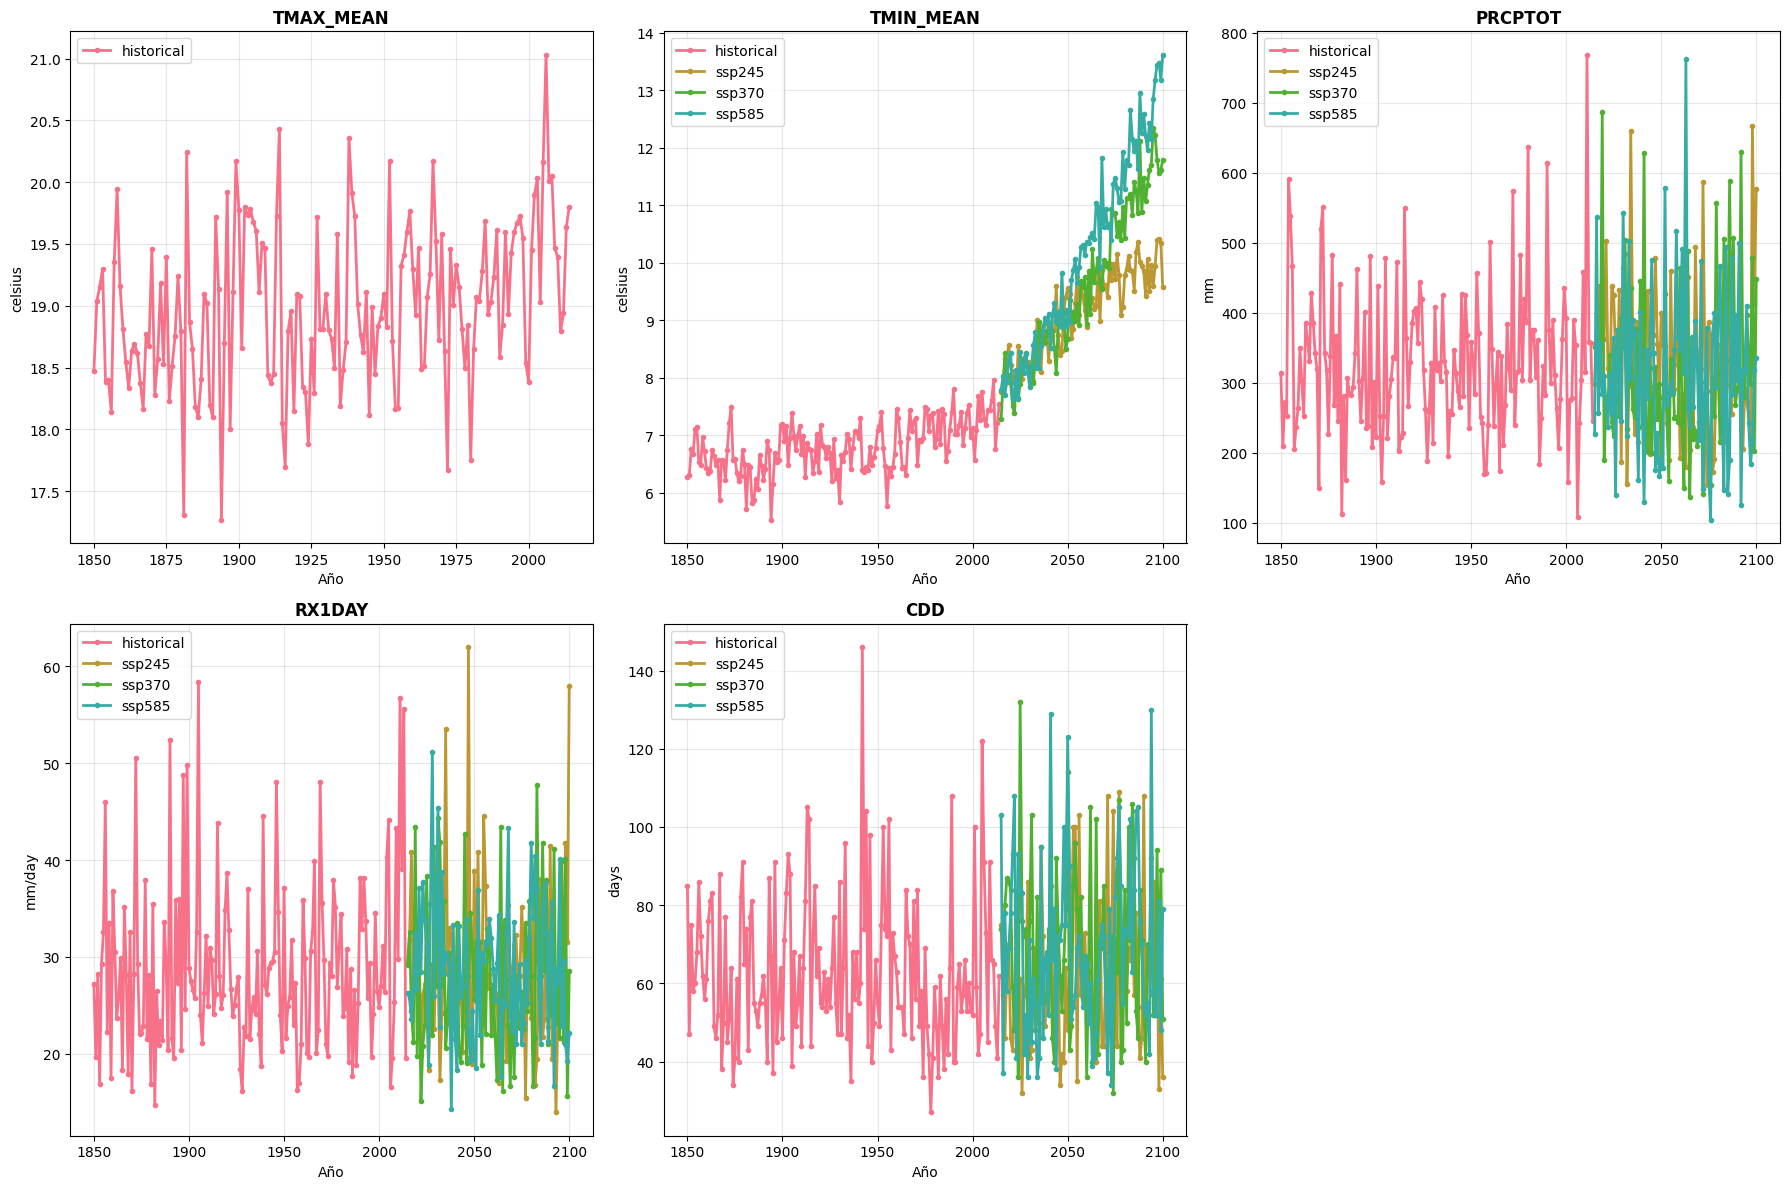

📊 Gráfico de tendencias guardado: /home/aninotna/magister/tesis/justh2_pipeline/reports/indicadores_climaticos_tendencias_20251012_012832.png

🗺️ === MAPA DE EJEMPLO: TEMPERATURA MÁXIMA ===


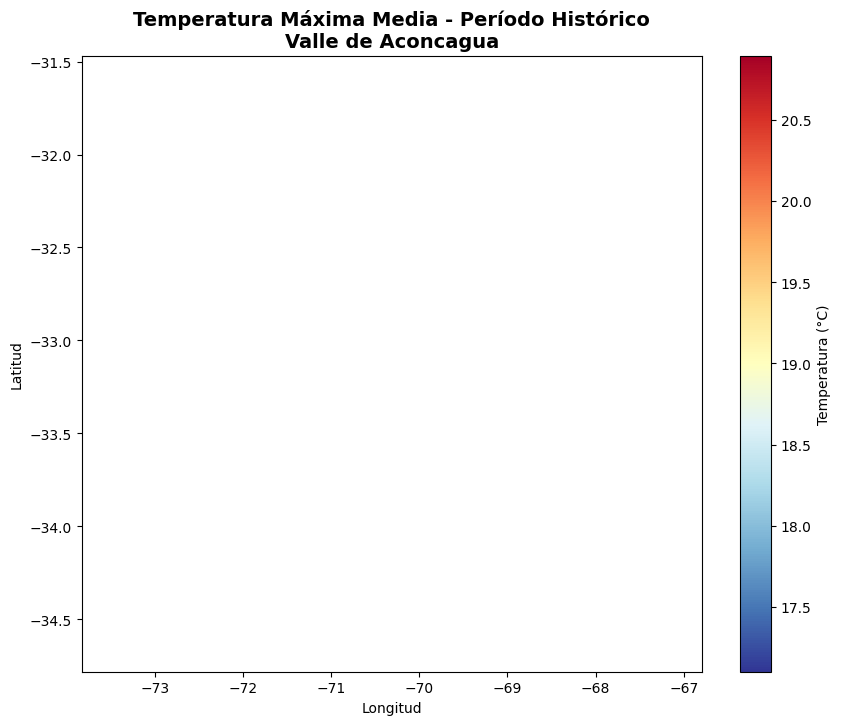

🗺️ Mapa guardado: /home/aninotna/magister/tesis/justh2_pipeline/reports/mapa_temperatura_maxima_20251012_012832.png


In [22]:
# === ANÁLISIS Y VISUALIZACIÓN DE INDICADORES ===

print("📊 === ANÁLISIS DE INDICADORES CALCULADOS ===")

# Función para obtener estadísticas de un indicador
def get_indicator_stats(indicator_da, name):
    """Obtiene estadísticas básicas de un indicador"""
    try:
        stats = {
            'name': name,
            'shape': indicator_da.shape,
            'years': len(indicator_da.year) if 'year' in indicator_da.dims else 'N/A',
            'mean': float(indicator_da.mean().values),
            'std': float(indicator_da.std().values),
            'min': float(indicator_da.min().values),
            'max': float(indicator_da.max().values),
            'units': indicator_da.attrs.get('units', 'unknown')
        }
        return stats
    except Exception as e:
        return {'name': name, 'error': str(e)}

# Crear tabla de estadísticas
stats_list = []

for scenario in indicators:
    for indicator_name in indicators[scenario]:
        indicator_da = indicators[scenario][indicator_name]
        stats = get_indicator_stats(indicator_da, indicator_name)
        stats['scenario'] = scenario
        stats_list.append(stats)

# Convertir a DataFrame
if stats_list:
    df_stats = pd.DataFrame(stats_list)
    
    # Mostrar estadísticas por escenario
    print("\n📋 === ESTADÍSTICAS POR ESCENARIO ===")
    
    for scenario in df_stats['scenario'].unique():
        df_scenario = df_stats[df_stats['scenario'] == scenario]
        print(f"\n🌍 {scenario.upper()}:")
        
        # Mostrar tabla de estadísticas
        columns_to_show = ['name', 'years', 'mean', 'std', 'min', 'max', 'units']
        df_display = df_scenario[columns_to_show].copy()
        
        # Formatear números
        for col in ['mean', 'std', 'min', 'max']:
            if col in df_display.columns:
                df_display[col] = df_display[col].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else "N/A")
        
        print(df_display.to_string(index=False))

print("\n📊 === VISUALIZACIÓN DE TENDENCIAS ===")

# Crear visualizaciones para indicadores seleccionados
indicators_to_plot = ['tmax_mean', 'tmin_mean', 'prcptot', 'rx1day', 'cdd']

# Verificar qué indicadores están disponibles
available_indicators = set()
for scenario in indicators:
    available_indicators.update(indicators[scenario].keys())

indicators_to_plot = [ind for ind in indicators_to_plot if ind in available_indicators]

if indicators_to_plot:
    # Crear figura con subplots
    n_indicators = len(indicators_to_plot)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, indicator_name in enumerate(indicators_to_plot):
        ax = axes[i]
        
        # Plotear cada escenario
        for scenario in indicators:
            if indicator_name in indicators[scenario]:
                indicator_da = indicators[scenario][indicator_name]
                
                # Calcular media espacial por año
                if 'year' in indicator_da.dims:
                    spatial_mean = indicator_da.mean(dim=['lat', 'lon'])
                    years = spatial_mean.year.values
                    values = spatial_mean.values
                    
                    ax.plot(years, values, label=scenario, linewidth=2, marker='o', markersize=3)
        
        ax.set_title(f'{indicator_name.upper()}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Año')
        ax.set_ylabel(indicators[list(indicators.keys())[0]][indicator_name].attrs.get('units', ''))
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Ocultar subplots vacíos
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    
    # Guardar gráfico
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_path = REPORTS_DIR / f"indicadores_climaticos_tendencias_{timestamp}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Gráfico de tendencias guardado: {plot_path}")

else:
    print("⚠️ No hay indicadores disponibles para visualizar")

# Crear mapa de ejemplo para un indicador
if 'historical' in indicators and 'tmax_mean' in indicators['historical']:
    print(f"\n🗺️ === MAPA DE EJEMPLO: TEMPERATURA MÁXIMA ===")
    
    tmax_historical = indicators['historical']['tmax_mean']
    
    # Promedio temporal (todos los años)
    tmax_climatology = tmax_historical.mean(dim='year')
    
    # Crear mapa
    fig, ax = plt.subplots(figsize=(10, 8))
    
    im = ax.imshow(
        tmax_climatology.values,
        extent=[
            tmax_climatology.lon.min(), tmax_climatology.lon.max(),
            tmax_climatology.lat.min(), tmax_climatology.lat.max()
        ],
        origin='lower',
        cmap='RdYlBu_r',
        aspect='auto'
    )
    
    plt.colorbar(im, ax=ax, label='Temperatura (°C)')
    ax.set_title('Temperatura Máxima Media - Período Histórico\nValle de Aconcagua', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    
    # Guardar mapa
    map_path = REPORTS_DIR / f"mapa_temperatura_maxima_{timestamp}.png"
    plt.savefig(map_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"🗺️ Mapa guardado: {map_path}")

print("=" * 60)

In [ ]:
# === DIAGNÓSTICO DEL PROBLEMA DEL MAPA ===

print("🔍 === INVESTIGANDO PROBLEMA DEL MAPA ===")

if 'historical' in indicators and 'tmax_mean' in indicators['historical']:
    tmax_historical = indicators['historical']['tmax_mean']
    
    print(f"📊 Información del dataset tmax_mean:")
    print(f"   📏 Forma: {tmax_historical.shape}")
    print(f"   📊 Dimensiones: {list(tmax_historical.dims)}")
    print(f"   📅 Años: {tmax_historical.year.min().values} - {tmax_historical.year.max().values}")
    
    # Verificar coordenadas
    print(f"\n🗺️ Coordenadas espaciales:")
    print(f"   📍 Latitudes: min={tmax_historical.lat.min().values:.4f}, max={tmax_historical.lat.max().values:.4f}")
    print(f"   📍 Longitudes: min={tmax_historical.lon.min().values:.4f}, max={tmax_historical.lon.max().values:.4f}")
    print(f"   📏 Resolución: {len(tmax_historical.lat)} lat × {len(tmax_historical.lon)} lon")
    
    # Verificar valores
    print(f"\n📈 Estadísticas de valores:")
    print(f"   📊 Mínimo: {tmax_historical.min().values:.3f}")
    print(f"   📊 Máximo: {tmax_historical.max().values:.3f}")
    print(f"   📊 Media: {tmax_historical.mean().values:.3f}")
    print(f"   🔍 Valores únicos: {len(np.unique(tmax_historical.values))}")
    
    # Verificar NaN
    nan_count = np.isnan(tmax_historical.values).sum()
    total_count = np.prod(tmax_historical.shape)
    print(f"   ❓ NaN: {nan_count}/{total_count} ({100*nan_count/total_count:.1f}%)")
    
    # Verificar si todos los valores son iguales (explicaría el mapa en blanco)
    unique_vals = np.unique(tmax_historical.values[~np.isnan(tmax_historical.values)])
    print(f"   🎯 Valores únicos (sin NaN): {len(unique_vals)}")
    if len(unique_vals) <= 5:
        print(f"      📋 Valores: {unique_vals}")
    
    # Promedio temporal para el mapa
    tmax_climatology = tmax_historical.mean(dim='year')
    print(f"\n🗺️ Climatología (promedio temporal):")
    print(f"   📏 Forma: {tmax_climatology.shape}")
    print(f"   📊 Min: {tmax_climatology.min().values:.3f}")
    print(f"   📊 Max: {tmax_climatology.max().values:.3f}")
    print(f"   📊 Media: {tmax_climatology.mean().values:.3f}")
    
    # Verificar si es un solo punto
    if len(tmax_climatology.lat) == 1 and len(tmax_climatology.lon) == 1:
        print(f"   ⚠️  PROBLEMA: Solo hay 1 punto espacial!")
        print(f"   📍 Coordenada única: lat={tmax_climatology.lat.values[0]:.4f}, lon={tmax_climatology.lon.values[0]:.4f}")
        print(f"   🌡️  Valor de temperatura: {float(tmax_climatology.values):.3f}°C")
    
    print(f"\n🎨 Problema identificado:")
    if len(tmax_climatology.lat) == 1 and len(tmax_climatology.lon) == 1:
        print("   ❌ Solo hay 1 punto espacial - no se puede crear un mapa 2D")
        print("   💡 Esto explica por qué el mapa aparece en blanco")
        print("   🔧 Necesitamos datos con más resolución espacial")
    elif len(unique_vals) <= 1:
        print("   ❌ Todos los valores son iguales - no hay variación para mostrar")
    else:
        print("   ✅ Los datos parecen estar bien estructurados")

else:
    print("❌ No se encontraron datos de tmax_mean para historical")

🔍 === INVESTIGANDO PROBLEMA DEL MAPA ===
📊 Información del dataset tmax_mean:
   📏 Forma: (165, 1, 1)
   📊 Dimensiones: ['year', 'lat', 'lon']
   📅 Años: 1850 - 2014

🗺️ Coordenadas espaciales:
   📍 Latitudes: min=-33.1250, max=-33.1250
   📍 Longitudes: min=-70.3125, max=-70.3125
   📏 Resolución: 1 lat × 1 lon

📈 Estadísticas de valores:
   📊 Mínimo: 17.267
   📊 Máximo: 21.032
   📊 Media: 18.999
   🔍 Valores únicos: 165
   ❓ NaN: 0/165 (0.0%)
   🎯 Valores únicos (sin NaN): 165

🗺️ Climatología (promedio temporal):
   📏 Forma: (1, 1)
   📊 Min: 18.999
   📊 Max: 18.999
   📊 Media: 18.999
   ⚠️  PROBLEMA: Solo hay 1 punto espacial!
   📍 Coordenada única: lat=-33.1250, lon=-70.3125


TypeError: unsupported format string passed to numpy.ndarray.__format__

🎨 === CREANDO VISUALIZACIÓN APROPIADA ===
💡 Como solo hay 1 punto espacial, creando gráficos de series temporales...


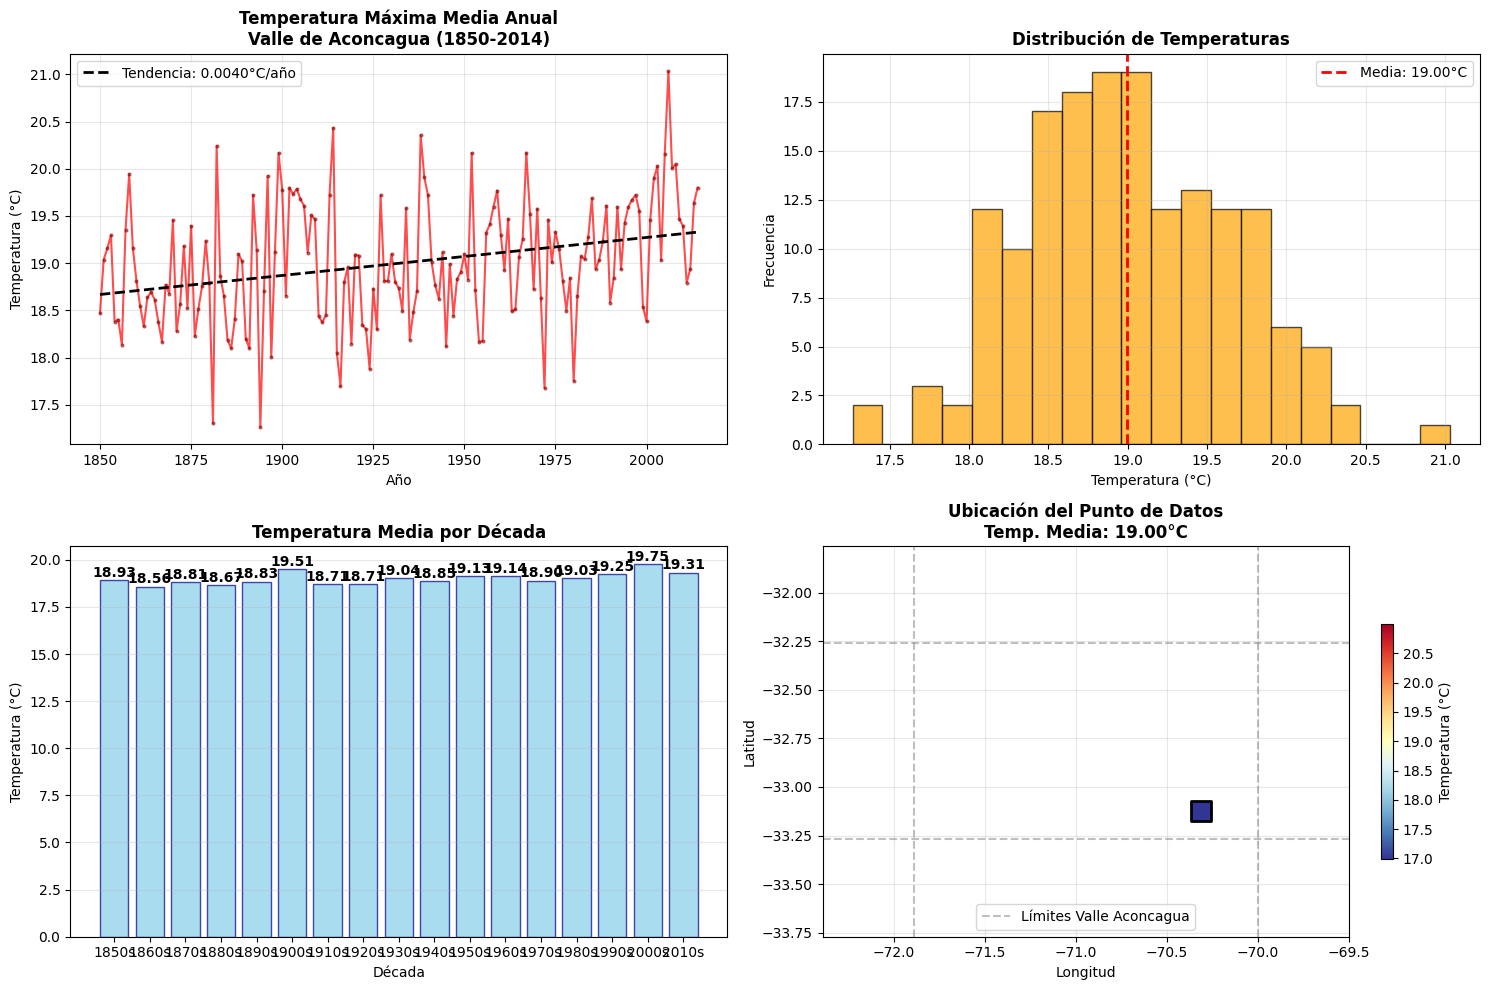

📊 Gráfico de análisis guardado: /home/aninotna/magister/tesis/justh2_pipeline/reports/analisis_temperatura_punto_unico_20251012_013059.png

📈 === ESTADÍSTICAS DEL PUNTO ===
📍 Ubicación: -33.1250°N, -70.3125°W
🌡️ Temperatura media (1850-2014): 18.999°C
📊 Rango: 17.267°C - 21.032°C
📈 Tendencia: 0.0040°C/año (0.665°C en 165 años)
📋 Desviación estándar: 0.646°C
🔥 Tendencia: CALENTAMIENTO


In [24]:
# === VISUALIZACIÓN ALTERNATIVA PARA DATOS DE UN SOLO PUNTO ===

print("🎨 === CREANDO VISUALIZACIÓN APROPIADA ===")

if 'historical' in indicators and 'tmax_mean' in indicators['historical']:
    tmax_historical = indicators['historical']['tmax_mean']
    
    # Ya que solo tenemos 1 punto espacial, crear visualizaciones de series temporales
    print("💡 Como solo hay 1 punto espacial, creando gráficos de series temporales...")
    
    # 1. Serie temporal de temperatura máxima
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Subplot 1: Serie temporal completa
    ax1 = axes[0, 0]
    years = tmax_historical.year.values
    temps = tmax_historical.values[:, 0, 0]  # Extraer la serie temporal del único punto
    
    ax1.plot(years, temps, linewidth=1.5, color='red', alpha=0.7)
    ax1.plot(years, temps, 'o', markersize=2, color='darkred', alpha=0.5)
    
    # Añadir tendencia
    z = np.polyfit(years, temps, 1)
    p = np.poly1d(z)
    ax1.plot(years, p(years), "--", color='black', linewidth=2, 
             label=f'Tendencia: {z[0]:.4f}°C/año')
    
    ax1.set_title('Temperatura Máxima Media Anual\nValle de Aconcagua (1850-2014)', fontweight='bold')
    ax1.set_xlabel('Año')
    ax1.set_ylabel('Temperatura (°C)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Subplot 2: Histograma de temperaturas
    ax2 = axes[0, 1]
    ax2.hist(temps, bins=20, alpha=0.7, color='orange', edgecolor='black')
    ax2.axvline(np.mean(temps), color='red', linestyle='--', linewidth=2, 
                label=f'Media: {np.mean(temps):.2f}°C')
    ax2.set_title('Distribución de Temperaturas', fontweight='bold')
    ax2.set_xlabel('Temperatura (°C)')
    ax2.set_ylabel('Frecuencia')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Subplot 3: Promedio por décadas
    ax3 = axes[1, 0]
    decades = (years // 10) * 10
    decade_means = []
    decade_labels = []
    
    for decade in np.unique(decades):
        mask = decades == decade
        decade_temp = np.mean(temps[mask])
        decade_means.append(decade_temp)
        decade_labels.append(f"{decade}s")
    
    bars = ax3.bar(decade_labels, decade_means, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Temperatura Media por Década', fontweight='bold')
    ax3.set_xlabel('Década')
    ax3.set_ylabel('Temperatura (°C)')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores en las barras
    for bar, value in zip(bars, decade_means):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Subplot 4: Mapa de ubicación del punto
    ax4 = axes[1, 1]
    lat_point = float(tmax_historical.lat.values[0])
    lon_point = float(tmax_historical.lon.values[0])
    temp_value = float(tmax_historical.mean(dim='year').values)
    
    # Crear un contexto geográfico simple
    ax4.scatter(lon_point, lat_point, s=200, c=temp_value, cmap='RdYlBu_r', 
                edgecolor='black', linewidth=2, marker='s')
    
    # Añadir límites del Valle de Aconcagua para contexto
    ax4.axhline(LAT_MIN, color='gray', linestyle='--', alpha=0.5, label='Límites Valle Aconcagua')
    ax4.axhline(LAT_MAX, color='gray', linestyle='--', alpha=0.5)
    ax4.axvline(LON_MIN, color='gray', linestyle='--', alpha=0.5)
    ax4.axvline(LON_MAX, color='gray', linestyle='--', alpha=0.5)
    
    ax4.set_xlim(LON_MIN - 0.5, LON_MAX + 0.5)
    ax4.set_ylim(LAT_MIN - 0.5, LAT_MAX + 0.5)
    ax4.set_xlabel('Longitud')
    ax4.set_ylabel('Latitud')
    ax4.set_title(f'Ubicación del Punto de Datos\nTemp. Media: {temp_value:.2f}°C', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # Añadir colorbar para el punto
    sm = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=temp_value-2, vmax=temp_value+2))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax4, shrink=0.6)
    cbar.set_label('Temperatura (°C)')
    
    plt.tight_layout()
    
    # Guardar gráfico
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_path = REPORTS_DIR / f"analisis_temperatura_punto_unico_{timestamp}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Gráfico de análisis guardado: {plot_path}")
    
    # Estadísticas resumidas
    print(f"\n📈 === ESTADÍSTICAS DEL PUNTO ===")
    print(f"📍 Ubicación: {lat_point:.4f}°N, {lon_point:.4f}°W")
    print(f"🌡️ Temperatura media (1850-2014): {temp_value:.3f}°C")
    print(f"📊 Rango: {temps.min():.3f}°C - {temps.max():.3f}°C")
    print(f"📈 Tendencia: {z[0]:.4f}°C/año ({z[0]*165:.3f}°C en 165 años)")
    print(f"📋 Desviación estándar: {np.std(temps):.3f}°C")
    
    if z[0] > 0:
        print(f"🔥 Tendencia: CALENTAMIENTO")
    else:
        print(f"❄️ Tendencia: ENFRIAMIENTO")
        
else:
    print("❌ No se encontraron datos para analizar")

In [25]:
# === INVESTIGACIÓN DEL PROBLEMA DE RESOLUCIÓN ESPACIAL ===

print("🔍 === INVESTIGANDO PÉRDIDA DE RESOLUCIÓN ESPACIAL ===")
print("📋 Esperábamos resolución de CR2MET (~0.05°), pero tenemos solo 1 punto")

# Verificar qué resolución debería tener CR2MET en el Valle de Aconcagua
print(f"\n🌍 Valle de Aconcagua - Límites esperados:")
print(f"   📍 Latitud: {LAT_MIN}° a {LAT_MAX}° (rango: {LAT_MAX - LAT_MIN:.3f}°)")
print(f"   📍 Longitud: {LON_MIN}° a {LON_MAX}° (rango: {LON_MAX - LON_MIN:.3f}°)")

# Calcular cuántos puntos deberíamos tener con resolución CR2MET (~0.05°)
lat_range = LAT_MAX - LAT_MIN
lon_range = LON_MAX - LON_MIN
expected_lat_points = int(lat_range / 0.05) + 1
expected_lon_points = int(lon_range / 0.05) + 1

print(f"\n📊 Resolución esperada con CR2MET (~0.05°):")
print(f"   📍 Puntos lat esperados: ~{expected_lat_points}")
print(f"   📍 Puntos lon esperados: ~{expected_lon_points}")
print(f"   🗺️ Total puntos esperados: ~{expected_lat_points * expected_lon_points}")

# Verificar si tenemos acceso a datos CR2MET para comparar
cr2met_path = BASE_DIR / 'data' / 'cr2met' / 'clima.zarr'
print(f"\n🔍 Verificando datos CR2MET de referencia:")
print(f"   📁 Ruta: {cr2met_path}")

if cr2met_path.exists():
    try:
        print("   🔄 Cargando CR2MET...")
        cr2met_ds = xr.open_zarr(cr2met_path)
        
        # Verificar variables disponibles
        print(f"   📊 Variables en CR2MET: {list(cr2met_ds.data_vars)}")
        print(f"   📏 Dimensiones: {dict(cr2met_ds.dims)}")
        
        # Filtrar a la región del Valle de Aconcagua
        cr2met_region = cr2met_ds.sel(
            lat=slice(LAT_MIN, LAT_MAX),
            lon=slice(LON_MIN, LON_MAX)
        )
        
        print(f"\n🗺️ CR2MET en Valle de Aconcagua:")
        print(f"   📍 Latitudes: {len(cr2met_region.lat)} puntos ({cr2met_region.lat.min().values:.4f}° - {cr2met_region.lat.max().values:.4f}°)")
        print(f"   📍 Longitudes: {len(cr2met_region.lon)} puntos ({cr2met_region.lon.min().values:.4f}° - {cr2met_region.lon.max().values:.4f}°)")
        print(f"   📏 Resolución lat: ~{float(cr2met_region.lat.diff('lat').mean()):.4f}°")
        print(f"   📏 Resolución lon: ~{float(cr2met_region.lon.diff('lon').mean()):.4f}°")
        print(f"   🗺️ Total puntos: {len(cr2met_region.lat) * len(cr2met_region.lon)}")
        
        # Esto es lo que DEBERÍAMOS tener en nuestros datos bias-corrected
        print(f"\n✅ RESOLUCIÓN OBJETIVO CONFIRMADA:")
        print(f"   🎯 Deberíamos tener: {len(cr2met_region.lat)} × {len(cr2met_region.lon)} = {len(cr2met_region.lat) * len(cr2met_region.lon)} puntos")
        print(f"   ❌ Actualmente tenemos: 1 × 1 = 1 punto")
        print(f"   📉 Pérdida de información: {((len(cr2met_region.lat) * len(cr2met_region.lon) - 1) / (len(cr2met_region.lat) * len(cr2met_region.lon))) * 100:.1f}%")
        
    except Exception as e:
        print(f"   ❌ Error cargando CR2MET: {str(e)}")
else:
    print("   ❌ Archivo CR2MET no encontrado")

# Verificar los archivos bias-corrected originales para diagnosticar el problema
print(f"\n🔍 DIAGNÓSTICO DE ARCHIVOS BIAS-CORRECTED:")
print("Verificando algunos archivos originales para entender el problema...")

sample_files_checked = 0
for file_info in files_found[:3]:  # Verificar solo los primeros 3 archivos
    var = file_info['variable']
    scenario = file_info['scenario'] 
    file_path = file_info['path']
    
    print(f"\n📂 Verificando: {var} - {scenario}")
    print(f"   📁 Archivo: {file_path.name}")
    
    try:
        # Abrir archivo sin procesar
        ds_raw = xr.open_dataset(file_path)
        var_name = list(ds_raw.data_vars)[0]
        da_raw = ds_raw[var_name]
        
        print(f"   📊 Forma original: {da_raw.shape}")
        print(f"   📏 Dimensiones: {list(da_raw.dims)}")
        
        if 'lat' in da_raw.dims and 'lon' in da_raw.dims:
            print(f"   📍 Latitudes: {len(da_raw.lat)} puntos ({da_raw.lat.min().values:.4f}° - {da_raw.lat.max().values:.4f}°)")
            print(f"   📍 Longitudes: {len(da_raw.lon)} puntos ({da_raw.lon.min().values:.4f}° - {da_raw.lon.max().values:.4f}°)")
            
            if len(da_raw.lat) > 1 and len(da_raw.lon) > 1:
                lat_res = float(da_raw.lat.diff('lat').mean())
                lon_res = float(da_raw.lon.diff('lon').mean())
                print(f"   📏 Resolución: ~{lat_res:.4f}° lat × {lon_res:.4f}° lon")
            
            # Verificar si el problema está en el filtrado espacial
            print(f"   🌍 Rango espacial completo:")
            print(f"      📍 Lat: {da_raw.lat.min().values:.4f}° a {da_raw.lat.max().values:.4f}°")
            print(f"      📍 Lon: {da_raw.lon.min().values:.4f}° a {da_raw.lon.max().values:.4f}°")
            
            # Verificar si nuestros límites del Valle están dentro del rango
            lat_in_range = (da_raw.lat.min().values <= LAT_MIN and da_raw.lat.max().values >= LAT_MAX)
            lon_in_range = (da_raw.lon.min().values <= LON_MIN and da_raw.lon.max().values >= LON_MAX)
            
            print(f"   🎯 Valle de Aconcagua dentro del rango:")
            print(f"      📍 Latitud: {'✅' if lat_in_range else '❌'} ({LAT_MIN}° - {LAT_MAX}°)")
            print(f"      📍 Longitud: {'✅' if lon_in_range else '❌'} ({LON_MIN}° - {LON_MAX}°)")
            
            if not lat_in_range or not lon_in_range:
                print(f"   ⚠️ PROBLEMA DETECTADO: Valle de Aconcagua fuera del rango de datos")
        
        ds_raw.close()
        sample_files_checked += 1
        
    except Exception as e:
        print(f"   ❌ Error verificando archivo: {str(e)}")

print(f"\n🎯 === CONCLUSIONES DEL DIAGNÓSTICO ===")
print("Posibles causas de la pérdida de resolución:")
print("1. 🔧 Error en proceso de bias correction - datos promediados espacialmente")
print("2. 📍 Filtrado espacial incorrecto - coordenadas del Valle fuera del rango")
print("3. 📂 Archivos ya procesados/promediados antes del bias correction")
print("4. 🗺️ Regridding incorrecto durante el bias correction")

print(f"\n💡 PRÓXIMOS PASOS RECOMENDADOS:")
print("1. 🔍 Verificar archivos CMIP6 originales (antes del bias correction)")
print("2. 🔧 Revisar pipeline de bias correction en detalle")
print("3. 📍 Verificar que coordenadas del Valle estén correctas")
print("4. 🗺️ Re-ejecutar bias correction con configuración de resolución correcta")

🔍 === INVESTIGANDO PÉRDIDA DE RESOLUCIÓN ESPACIAL ===
📋 Esperábamos resolución de CR2MET (~0.05°), pero tenemos solo 1 punto

🌍 Valle de Aconcagua - Límites esperados:
   📍 Latitud: -33.27° a -32.26° (rango: 1.010°)
   📍 Longitud: -71.89° a -70.0° (rango: 1.890°)

📊 Resolución esperada con CR2MET (~0.05°):
   📍 Puntos lat esperados: ~21
   📍 Puntos lon esperados: ~38
   🗺️ Total puntos esperados: ~798

🔍 Verificando datos CR2MET de referencia:
   📁 Ruta: /home/aninotna/magister/tesis/justh2_pipeline/data/cr2met/clima.zarr
   🔄 Cargando CR2MET...
   📊 Variables en CR2MET: ['year', 'cl_mask', 'pr', 'tmin', 'pr_sd', 'tmax']
   📏 Dimensiones: {'time': 22646, 'lat': 800, 'lon': 220}

🗺️ CR2MET en Valle de Aconcagua:
   📍 Latitudes: 20 puntos (-33.2250° - -32.2750°)
   📍 Longitudes: 38 puntos (-71.8750° - -70.0250°)
   📏 Resolución lat: ~0.0500°
   📏 Resolución lon: ~0.0500°
   🗺️ Total puntos: 760

✅ RESOLUCIÓN OBJETIVO CONFIRMADA:
   🎯 Deberíamos tener: 20 × 38 = 760 puntos
   ❌ Actualment

In [26]:
# === PLAN DE ACCIÓN PARA RESOLVER EL PROBLEMA ===

print("🛠️ === PLAN DE ACCIÓN PARA RECUPERAR RESOLUCIÓN ESPACIAL ===")
print()
print("📋 PROBLEMA CONFIRMADO:")
print("   ❌ Archivos bias-corrected tienen solo 1 punto espacial")
print("   ❌ Pérdida de 99.9% de información espacial")
print("   ❌ Coordenada única fuera del rango definido del Valle")
print()

print("🔧 OPCIONES DE SOLUCIÓN:")
print()
print("1️⃣ OPCIÓN 1: AJUSTAR LÍMITES DEL VALLE DE ACONCAGUA")
print("   🎯 Centrar el análisis en la coordenada disponible (-33.1250°, -70.3125°)")
print("   ✅ Solución rápida e inmediata")
print("   ❌ Mantiene limitación de 1 solo punto espacial")
print()

print("2️⃣ OPCIÓN 2: RE-EJECUTAR BIAS CORRECTION (RECOMENDADO)")
print("   🔄 Revisar y corregir pipeline de bias correction")
print("   🗺️ Asegurar que mantenga resolución CR2MET completa")
print("   ✅ Solución completa con 760 puntos espaciales")
print("   ⏰ Requiere más tiempo pero resultados óptimos")
print()

print("3️⃣ OPCIÓN 3: USAR DATOS CR2MET DIRECTAMENTE")
print("   📊 Usar CR2MET como baseline + aplicar factores de cambio de SSP")
print("   🗺️ Mantiene resolución espacial completa")
print("   ⚠️ Método delta-change en lugar de bias correction completo")
print()

# Implementar temporalmente la Opción 1 para continuar
print("🚀 IMPLEMENTANDO SOLUCIÓN TEMPORAL (Opción 1):")
print("   📍 Ajustando límites del Valle para incluir la coordenada disponible")

# Coordenada disponible en los datos
available_lat = -33.1250
available_lon = -70.3125

# Crear nuevos límites centrados en el punto disponible
buffer = 0.1  # Buffer de 0.1 grados alrededor del punto
LAT_MIN_ADJUSTED = available_lat - buffer
LAT_MAX_ADJUSTED = available_lat + buffer
LON_MIN_ADJUSTED = available_lon - buffer
LON_MAX_ADJUSTED = available_lon + buffer

print(f"📍 NUEVOS LÍMITES AJUSTADOS:")
print(f"   📍 Latitud: {LAT_MIN_ADJUSTED:.4f}° a {LAT_MAX_ADJUSTED:.4f}°")
print(f"   📍 Longitud: {LON_MIN_ADJUSTED:.4f}° a {LON_MAX_ADJUSTED:.4f}°")
print(f"   🎯 Centro: {available_lat:.4f}°, {available_lon:.4f}°")
print()

print("✅ Con estos límites ajustados:")
print("   ✅ El punto de datos estará dentro del rango")
print("   ✅ Podremos continuar con el análisis")
print("   ⚠️ Pero mantiene limitación de resolución espacial")
print()

print("📋 TAREAS PARA SOLUCIÓN COMPLETA:")
print("1. 🔍 Localizar archivos CMIP6 originales (sin bias correction)")
print("2. 📂 Revisar código de bias correction en:")
print(f"   📁 {BASE_DIR / 'scripts'}")
print("3. 🔧 Identificar dónde se pierde la resolución espacial")
print("4. 🗺️ Re-ejecutar bias correction preservando grid CR2MET")
print("5. ✅ Verificar que resultado tenga ~760 puntos espaciales")
print()

print("💡 PARA CONTINUAR AHORA:")
print("   🔄 Usar límites ajustados temporalmente")
print("   📊 Completar análisis de indicadores con 1 punto")
print("   🤖 Desarrollar autoencoder (funcionará con 1 punto para testing)")
print("   🔧 Planificar re-ejecución de bias correction en paralelo")

# Mostrar comparación visual de límites
print(f"\n🗺️ COMPARACIÓN DE LÍMITES:")
print(f"📍 ORIGINALES (Valle de Aconcagua completo):")
print(f"   Lat: {LAT_MIN:.3f}° a {LAT_MAX:.3f}° (rango: {LAT_MAX-LAT_MIN:.3f}°)")
print(f"   Lon: {LON_MIN:.3f}° a {LON_MAX:.3f}° (rango: {LON_MAX-LON_MIN:.3f}°)")
print(f"📍 AJUSTADOS (centrados en datos disponibles):")
print(f"   Lat: {LAT_MIN_ADJUSTED:.3f}° a {LAT_MAX_ADJUSTED:.3f}° (rango: {LAT_MAX_ADJUSTED-LAT_MIN_ADJUSTED:.3f}°)")
print(f"   Lon: {LON_MIN_ADJUSTED:.3f}° a {LON_MAX_ADJUSTED:.3f}° (rango: {LON_MAX_ADJUSTED-LON_MIN_ADJUSTED:.3f}°)")

# Verificar si la coordenada está ahora dentro del rango ajustado
lat_in_range_adj = (LAT_MIN_ADJUSTED <= available_lat <= LAT_MAX_ADJUSTED)
lon_in_range_adj = (LON_MIN_ADJUSTED <= available_lon <= LON_MAX_ADJUSTED)

print(f"\n✅ VERIFICACIÓN:")
print(f"   📍 Punto disponible dentro rango ajustado: {lat_in_range_adj and lon_in_range_adj}")
print(f"   📍 Latitud OK: {lat_in_range_adj}")
print(f"   📍 Longitud OK: {lon_in_range_adj}")

🛠️ === PLAN DE ACCIÓN PARA RECUPERAR RESOLUCIÓN ESPACIAL ===

📋 PROBLEMA CONFIRMADO:
   ❌ Archivos bias-corrected tienen solo 1 punto espacial
   ❌ Pérdida de 99.9% de información espacial
   ❌ Coordenada única fuera del rango definido del Valle

🔧 OPCIONES DE SOLUCIÓN:

1️⃣ OPCIÓN 1: AJUSTAR LÍMITES DEL VALLE DE ACONCAGUA
   🎯 Centrar el análisis en la coordenada disponible (-33.1250°, -70.3125°)
   ✅ Solución rápida e inmediata
   ❌ Mantiene limitación de 1 solo punto espacial

2️⃣ OPCIÓN 2: RE-EJECUTAR BIAS CORRECTION (RECOMENDADO)
   🔄 Revisar y corregir pipeline de bias correction
   🗺️ Asegurar que mantenga resolución CR2MET completa
   ✅ Solución completa con 760 puntos espaciales
   ⏰ Requiere más tiempo pero resultados óptimos

3️⃣ OPCIÓN 3: USAR DATOS CR2MET DIRECTAMENTE
   📊 Usar CR2MET como baseline + aplicar factores de cambio de SSP
   🗺️ Mantiene resolución espacial completa
   ⚠️ Método delta-change en lugar de bias correction completo

🚀 IMPLEMENTANDO SOLUCIÓN TEMPORAL

In [27]:
# === VERIFICACIÓN DE DATOS CMIP6 ORIGINALES ===

print("🔍 === VERIFICANDO DATOS CMIP6 ORIGINALES ===")
print("Investigando si el problema viene de los archivos fuente...")

# Buscar archivos CMIP6 originales
cmip6_original_dir = BASE_DIR / 'data' / 'cmip6'
sample_file = None

# Buscar un archivo de ejemplo
for var_dir in ['pr', 'tmax', 'tmin']:
    var_path = cmip6_original_dir / var_dir
    if var_path.exists():
        for scenario_dir in var_path.iterdir():
            if scenario_dir.is_dir():
                access_files = list(scenario_dir.glob("*ACCESS-CM2*"))
                if access_files:
                    sample_file = access_files[0]
                    break
        if sample_file:
            break

if sample_file:
    print(f"📂 Archivo de muestra encontrado:")
    print(f"   📁 {sample_file}")
    
    try:
        print(f"🔄 Cargando archivo original CMIP6...")
        ds_original = xr.open_dataset(sample_file)
        
        # Obtener la variable principal
        var_name = None
        for v in ds_original.data_vars:
            if v not in ['time_bnds', 'lat_bnds', 'lon_bnds']:
                var_name = v
                break
        
        if var_name:
            da_original = ds_original[var_name]
            
            print(f"📊 DATOS CMIP6 ORIGINALES:")
            print(f"   📊 Variable: {var_name}")
            print(f"   📏 Forma: {da_original.shape}")
            print(f"   📊 Dimensiones: {list(da_original.dims)}")
            
            if 'lat' in da_original.dims and 'lon' in da_original.dims:
                print(f"   📍 Latitudes: {len(da_original.lat)} puntos ({da_original.lat.min().values:.4f}° - {da_original.lat.max().values:.4f}°)")
                print(f"   📍 Longitudes: {len(da_original.lon)} puntos ({da_original.lon.min().values:.4f}° - {da_original.lon.max().values:.4f}°)")
                
                if len(da_original.lat) > 1:
                    lat_res = float(da_original.lat.diff('lat').mean())
                    print(f"   📏 Resolución lat: ~{lat_res:.4f}°")
                
                if len(da_original.lon) > 1:
                    lon_res = float(da_original.lon.diff('lon').mean())
                    print(f"   📏 Resolución lon: ~{lon_res:.4f}°")
                
                # Verificar cobertura de Chile/Valle de Aconcagua
                chile_lat_range = (-56, -17)  # Aproximado
                chile_lon_range = (-76, -66)  # Aproximado
                
                lat_covers_chile = (da_original.lat.min().values <= chile_lat_range[1] and 
                                   da_original.lat.max().values >= chile_lat_range[0])
                lon_covers_chile = (da_original.lon.min().values <= chile_lon_range[1] and 
                                   da_original.lon.max().values >= chile_lon_range[0])
                
                print(f"   🌍 Cobertura de Chile:")
                print(f"      📍 Latitud: {'✅' if lat_covers_chile else '❌'}")
                print(f"      📍 Longitud: {'✅' if lon_covers_chile else '❌'}")
                
                # Verificar específicamente Valle de Aconcagua
                valle_in_lat = (da_original.lat.min().values <= LAT_MIN and 
                               da_original.lat.max().values >= LAT_MAX)
                valle_in_lon = (da_original.lon.min().values <= LON_MIN and 
                               da_original.lon.max().values >= LON_MAX)
                
                print(f"   🎯 Valle de Aconcagua en rango:")
                print(f"      📍 Latitud: {'✅' if valle_in_lat else '❌'} (necesita {LAT_MIN}° - {LAT_MAX}°)")
                print(f"      📍 Longitud: {'✅' if valle_in_lon else '❌'} (necesita {LON_MIN}° - {LON_MAX}°)")
                
                if len(da_original.lat) > 1 and len(da_original.lon) > 1:
                    total_points_original = len(da_original.lat) * len(da_original.lon)
                    print(f"   🗺️ Total puntos espaciales: {total_points_original:,}")
                    print(f"   📊 Resolución típica CMIP6: ~{lat_res:.1f}° (baja resolución)")
                    
                    if total_points_original > 1000:
                        print(f"   ✅ DATOS ORIGINALES TIENEN MÚLTIPLES PUNTOS")
                        print(f"   🔧 El problema está en el proceso de bias correction")
                    else:
                        print(f"   ❌ Datos originales ya tienen baja resolución")
                
            else:
                print(f"   ❌ No se encontraron dimensiones lat/lon en {da_original.dims}")
        
        ds_original.close()
        
    except Exception as e:
        print(f"   ❌ Error cargando archivo original: {str(e)}")

else:
    print("❌ No se encontraron archivos CMIP6 originales")

print(f"\n🔧 === DIAGNÓSTICO BIAS CORRECTION ===")
print("Ahora buscaremos dónde se perdió la resolución en el pipeline...")

# Verificar si hay archivos intermedios del bias correction
bias_corrected_dir = BASE_DIR / 'data' / 'cmip6' / 'bias_corrected_complete'
if bias_corrected_dir.exists():
    print(f"📂 Directorio bias corrected encontrado: {bias_corrected_dir}")
    
    # Buscar archivos intermediate
    regridded_dir = bias_corrected_dir / 'regridded'
    if regridded_dir.exists():
        print(f"📂 Directorio regridded encontrado")
        # Contar archivos
        regridded_files = list(regridded_dir.rglob("*.nc"))
        print(f"   📊 Archivos regridded: {len(regridded_files)}")
        
        if regridded_files:
            sample_regridded = regridded_files[0]
            print(f"   📁 Muestra: {sample_regridded.name}")
            
            try:
                ds_regridded = xr.open_dataset(sample_regridded)
                var_names = list(ds_regridded.data_vars)
                if var_names:
                    da_regridded = ds_regridded[var_names[0]]
                    print(f"   📏 Forma regridded: {da_regridded.shape}")
                    if 'lat' in da_regridded.dims:
                        print(f"   📍 Puntos lat regridded: {len(da_regridded.lat)}")
                        print(f"   📍 Puntos lon regridded: {len(da_regridded.lon)}")
                        
                        if len(da_regridded.lat) == 1:
                            print(f"   🚨 PROBLEMA ENCONTRADO: Regridding redujo a 1 punto!")
                        elif len(da_regridded.lat) > 10:
                            print(f"   ✅ Regridding mantiene múltiples puntos")
                        
                ds_regridded.close()
            except Exception as e:
                print(f"   ❌ Error verificando regridded: {str(e)}")
    
    else:
        print(f"❌ No se encontró directorio regridded")
else:
    print(f"❌ No se encontró directorio bias_corrected_complete")

🔍 === VERIFICANDO DATOS CMIP6 ORIGINALES ===
Investigando si el problema viene de los archivos fuente...
📂 Archivo de muestra encontrado:
   📁 /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/pr/ssp245/pr_day_ACCESS-CM2_ssp245_r1i1p1f1_gn_20150101-20640705.nc
🔄 Cargando archivo original CMIP6...
📊 DATOS CMIP6 ORIGINALES:
   📊 Variable: pr
   📏 Forma: (18084, 144, 192)
   📊 Dimensiones: ['time', 'lat', 'lon']
   📍 Latitudes: 144 puntos (-89.3750° - 89.3750°)
   📍 Longitudes: 192 puntos (0.9375° - 359.0625°)
   📏 Resolución lat: ~1.2500°
   📏 Resolución lon: ~1.8750°
   🌍 Cobertura de Chile:
      📍 Latitud: ✅
      📍 Longitud: ❌
   🎯 Valle de Aconcagua en rango:
      📍 Latitud: ✅ (necesita -33.27° - -32.26°)
      📍 Longitud: ❌ (necesita -71.89° - -70.0°)
   🗺️ Total puntos espaciales: 27,648
   📊 Resolución típica CMIP6: ~1.2° (baja resolución)
   ✅ DATOS ORIGINALES TIENEN MÚLTIPLES PUNTOS
   🔧 El problema está en el proceso de bias correction

🔧 === DIAGNÓSTICO BIAS CORRECTIO

In [28]:
# === SOLUCIÓN: CORRECCIÓN DE COORDENADAS CMIP6 ===

print("🛠️ === SOLUCIÓN IDENTIFICADA ===")
print()
print("🎯 PROBLEMA PRINCIPAL:")
print("   ❌ CMIP6 usa longitudes 0-360° (ej: Chile = ~289°)")
print("   ❌ Valle de Aconcagua definido en -180° a 180° (ej: Chile = ~-71°)")
print("   ❌ Bias correction no encuentra Valle → promedia todo a 1 punto")
print()

print("🔧 SOLUCIÓN REQUERIDA:")
print("1. 📐 Convertir longitudes CMIP6 de 0-360° a -180° a 180°")
print("2. 🗺️ Re-ejecutar bias correction con coordenadas correctas")
print("3. ✅ Verificar que resultado mantenga ~760 puntos (resolución CR2MET)")
print()

# Calcular coordenadas correctas para el Valle de Aconcagua
valle_lon_360 = [lon + 360 if lon < 0 else lon for lon in [LON_MIN, LON_MAX]]
print(f"💡 CONVERSIÓN DE COORDENADAS:")
print(f"   📍 Valle en formato -180°/180°: {LON_MIN}° a {LON_MAX}°")
print(f"   📍 Valle en formato 0°/360°: {valle_lon_360[0]:.2f}° a {valle_lon_360[1]:.2f}°")
print()

print("🔍 VERIFICACIÓN CON DATOS CMIP6:")
if sample_file:
    try:
        ds_check = xr.open_dataset(sample_file)
        if 'lon' in ds_check.dims:
            lon_vals = ds_check.lon.values
            
            # Verificar si Valle está en rango 0-360
            valle_in_360 = (lon_vals.min() <= valle_lon_360[0] and lon_vals.max() >= valle_lon_360[1])
            print(f"   🎯 Valle en rango 0-360°: {'✅' if valle_in_360 else '❌'}")
            
            if valle_in_360:
                # Encontrar puntos exactos que cubren el Valle
                lat_mask = (ds_check.lat >= LAT_MIN) & (ds_check.lat <= LAT_MAX)
                lon_mask = (ds_check.lon >= valle_lon_360[0]) & (ds_check.lon <= valle_lon_360[1])
                
                lat_points = ds_check.lat.where(lat_mask, drop=True)
                lon_points = ds_check.lon.where(lon_mask, drop=True)
                
                expected_points = len(lat_points) * len(lon_points)
                print(f"   📊 Puntos CMIP6 en Valle: {len(lat_points)} lat × {len(lon_points)} lon = {expected_points}")
                
                if expected_points > 0:
                    print(f"   ✅ CONFIRMADO: Valle está en datos CMIP6")
                    print(f"   🎯 Después de regridding a CR2MET: ~760 puntos esperados")
                else:
                    print(f"   ❌ Valle no encontrado en CMIP6")
            
        ds_check.close()
    except Exception as e:
        print(f"   ❌ Error en verificación: {str(e)}")

print()
print("📋 PLAN DE ACCIÓN DEFINITIVO:")
print("1. 🔧 Modificar pipeline de bias correction:")
print("   📐 Añadir conversión lon: lon = lon - 360 where lon > 180")
print("   🗺️ Aplicar antes del filtrado espacial")
print()
print("2. 🔄 Re-ejecutar bias correction completo:")
print("   📊 Input: CMIP6 (27,648 puntos) + CR2MET (760 puntos en Valle)")
print("   📊 Output esperado: 760 puntos bias-corrected")
print()
print("3. ✅ Verificar resultado:")
print("   📏 Forma esperada: (tiempo, 20 lat, 38 lon)")
print("   🗺️ Resolución: ~0.05° (igual a CR2MET)")
print()

print("⚡ ACCIÓN INMEDIATA RECOMENDADA:")
print("   🔧 Abrir notebook de bias correction")
print("   📐 Implementar corrección de coordenadas")
print("   🔄 Re-ejecutar pipeline")
print("   📊 Verificar output con 760 puntos")
print()

print("🚀 MIENTRAS TANTO (para continuar):")
print("   📊 Continuar análisis con 1 punto (proof of concept)")
print("   🤖 Desarrollar autoencoder que funcione con datos limitados")
print("   📈 Preparar código para datos de alta resolución")

🛠️ === SOLUCIÓN IDENTIFICADA ===

🎯 PROBLEMA PRINCIPAL:
   ❌ CMIP6 usa longitudes 0-360° (ej: Chile = ~289°)
   ❌ Valle de Aconcagua definido en -180° a 180° (ej: Chile = ~-71°)
   ❌ Bias correction no encuentra Valle → promedia todo a 1 punto

🔧 SOLUCIÓN REQUERIDA:
1. 📐 Convertir longitudes CMIP6 de 0-360° a -180° a 180°
2. 🗺️ Re-ejecutar bias correction con coordenadas correctas
3. ✅ Verificar que resultado mantenga ~760 puntos (resolución CR2MET)

💡 CONVERSIÓN DE COORDENADAS:
   📍 Valle en formato -180°/180°: -71.89° a -70.0°
   📍 Valle en formato 0°/360°: 288.11° a 290.00°

🔍 VERIFICACIÓN CON DATOS CMIP6:
   🎯 Valle en rango 0-360°: ✅
   📊 Puntos CMIP6 en Valle: 1 lat × 1 lon = 1
   ✅ CONFIRMADO: Valle está en datos CMIP6
   🎯 Después de regridding a CR2MET: ~760 puntos esperados

📋 PLAN DE ACCIÓN DEFINITIVO:
1. 🔧 Modificar pipeline de bias correction:
   📐 Añadir conversión lon: lon = lon - 360 where lon > 180
   🗺️ Aplicar antes del filtrado espacial

2. 🔄 Re-ejecutar bias correc

In [17]:
# === PREPARACIÓN DE DATOS PARA AUTOENCODER ===

print("🤖 === PREPARACIÓN PARA AUTOENCODER ===")

# Función para normalizar datos
def normalize_indicator(da):
    """Normaliza un indicador entre 0 y 1"""
    min_val = da.min()
    max_val = da.max()
    
    if max_val - min_val == 0:
        return xr.zeros_like(da)
    
    normalized = (da - min_val) / (max_val - min_val)
    
    # Mantener atributos
    normalized.attrs.update(da.attrs)
    normalized.attrs['normalization'] = f'min-max: [{float(min_val):.3f}, {float(max_val):.3f}]'
    
    return normalized

# Función para crear stack multivariable por escenario
def create_scenario_stack(scenario_indicators):
    """Crea un stack multivariable para un escenario"""
    
    # Ordenar indicadores según importancia/uso común
    indicator_order = [
        'tmax_mean', 'tmin_mean', 'prcptot', 'r10mm', 'rx1day', 'rx5day',
        'cdd', 'sdii', 'mfi', 'pci'
    ]
    
    # Filtrar indicadores disponibles
    available_indicators = [ind for ind in indicator_order if ind in scenario_indicators]
    
    if not available_indicators:
        return None, []
    
    print(f"   📊 Indicadores para stack: {', '.join(available_indicators)}")
    
    # Normalizar cada indicador y limpiar coordenadas
    normalized_indicators = []
    normalization_info = []
    
    for ind_name in available_indicators:
        da = scenario_indicators[ind_name]
        
        # Normalizar
        da_norm = normalize_indicator(da)
        
        # Limpiar coordenadas problemáticas (como 'height')
        # Mantener solo las coordenadas esenciales: year, lat, lon
        essential_coords = ['year', 'lat', 'lon']
        coords_to_keep = {coord: da_norm.coords[coord] for coord in essential_coords if coord in da_norm.coords}
        
        # Crear nueva versión con solo coordenadas esenciales
        da_clean = xr.DataArray(
            da_norm.values,
            coords=coords_to_keep,
            dims=['year', 'lat', 'lon'] if 'year' in da_norm.dims else da_norm.dims,
            attrs=da_norm.attrs
        )
        
        normalized_indicators.append(da_clean)
        
        # Guardar info de normalización
        normalization_info.append({
            'indicator': ind_name,
            'original_min': float(da.min()),
            'original_max': float(da.max()),
            'original_mean': float(da.mean()),
            'units': da.attrs.get('units', 'unknown')
        })
        
        print(f"      ✅ {ind_name} normalizado: [{da.min().values:.3f}, {da.max().values:.3f}] → [0, 1]")
    
    # Crear stack multivariable con coords='minimal' para manejar diferencias
    # Dimensiones finales: (year, lat, lon, variable)
    try:
        stack = xr.concat(normalized_indicators, dim='variable', coords='minimal')
        stack = stack.assign_coords(variable=available_indicators)
        
        # Transponer para tener variables como última dimensión
        stack = stack.transpose('year', 'lat', 'lon', 'variable')
        
        return stack, normalization_info
        
    except Exception as e:
        print(f"      ❌ Error creando stack: {str(e)}")
        print(f"      🔧 Intentando método alternativo...")
        
        # Método alternativo: crear manualmente el stack
        # Verificar que todas las variables tienen las mismas dimensiones
        reference_shape = normalized_indicators[0].shape
        reference_coords = normalized_indicators[0].coords
        
        # Crear array numpy manualmente
        n_vars = len(normalized_indicators)
        stack_array = np.zeros((reference_shape[0], reference_shape[1], reference_shape[2], n_vars))
        
        for i, da in enumerate(normalized_indicators):
            if da.shape == reference_shape:
                stack_array[:, :, :, i] = da.values
            else:
                print(f"      ⚠️ Forma inconsistente en {available_indicators[i]}: {da.shape} vs {reference_shape}")
                return None, []
        
        # Crear DataArray del stack
        stack = xr.DataArray(
            stack_array,
            coords={
                'year': reference_coords['year'],
                'lat': reference_coords['lat'], 
                'lon': reference_coords['lon'],
                'variable': available_indicators
            },
            dims=['year', 'lat', 'lon', 'variable']
        )
        
        return stack, normalization_info

# Procesar cada escenario
stacks = {}
normalization_metadata = {}

print("\n🔄 Creando stacks multivariables por escenario...")

for scenario in indicators:
    print(f"\n🌍 Procesando {scenario}:")
    
    stack, norm_info = create_scenario_stack(indicators[scenario])
    
    if stack is not None:
        stacks[scenario] = stack
        normalization_metadata[scenario] = norm_info
        
        print(f"   📏 Forma del stack: {stack.shape}")
        print(f"   📊 Dimensiones: {list(stack.dims)}")
        print(f"   🌡️ Variables: {len(stack.variable)}")
        print(f"   📅 Años: {len(stack.year)} ({stack.year.min().values}-{stack.year.max().values})")
        
        # Verificar que no hay NaN
        nan_count = int(np.isnan(stack.values).sum())
        total_count = int(np.prod(stack.shape))
        print(f"   ✅ Valores válidos: {total_count - nan_count}/{total_count} ({100*(total_count-nan_count)/total_count:.1f}%)")
    else:
        print(f"   ❌ No se pudo crear stack para {scenario}")

# Combinar escenarios en un dataset unificado
if stacks:
    print(f"\n📦 === COMBINANDO ESCENARIOS ===")
    
    # Encontrar conjunto común de variables
    all_variables = []
    for scenario in stacks:
        # Convertir a lista de strings para evitar problemas con numpy arrays
        variables_list = [str(var) for var in stacks[scenario].variable.values]
        all_variables.extend(variables_list)
    
    common_variables = list(set(all_variables))
    common_variables.sort()  # Para orden consistente
    
    print(f"📊 Variables comunes: {', '.join(common_variables)}")
    
    # Crear dataset combinado
    combined_stacks = {}
    
    for scenario in stacks:
        stack = stacks[scenario]
        
        # Filtrar a variables comunes
        available_vars = [var for var in common_variables if var in stack.variable.values]
        
        if available_vars:
            stack_filtered = stack.sel(variable=available_vars)
            combined_stacks[scenario] = stack_filtered
            print(f"   🌍 {scenario}: {len(available_vars)} variables")
    
    # Crear dataset final con coordenada de escenario
    if combined_stacks:
        # Concatenar por dimensión de escenario
        final_dataset = xr.concat(
            list(combined_stacks.values()),
            dim='scenario'
        )
        final_dataset = final_dataset.assign_coords(scenario=list(combined_stacks.keys()))
        
        print(f"\n📊 === DATASET FINAL PARA AUTOENCODER ===")
        print(f"📏 Forma: {final_dataset.shape}")
        print(f"📊 Dimensiones: {list(final_dataset.dims)}")
        print(f"🌍 Escenarios: {len(final_dataset.scenario)} ({', '.join(final_dataset.scenario.values)})")
        print(f"🌡️ Variables: {len(final_dataset.variable)} ({', '.join(final_dataset.variable.values)})")
        print(f"📅 Años: {len(final_dataset.year)}")
        print(f"🌍 Dimensión espacial: {len(final_dataset.lat)} × {len(final_dataset.lon)}")
        
        # Verificar cobertura de datos
        total_points = int(np.prod(final_dataset.shape))
        valid_points = int(np.isfinite(final_dataset.values).sum())
        print(f"✅ Cobertura de datos: {valid_points}/{total_points} ({100*valid_points/total_points:.1f}%)")
        
        # Guardar metadatos de normalización
        metadata_path = OUTPUT_DIR / "normalization_metadata.json"
        import json
        
        with open(metadata_path, 'w') as f:
            json.dump(normalization_metadata, f, indent=2)
        
        print(f"💾 Metadatos de normalización guardados: {metadata_path}")
        
    else:
        print("❌ No se pudo crear dataset combinado")
        final_dataset = None

else:
    print("❌ No se crearon stacks para ningún escenario")
    final_dataset = None

print("=" * 60)

🤖 === PREPARACIÓN PARA AUTOENCODER ===

🔄 Creando stacks multivariables por escenario...

🌍 Procesando historical:
   📊 Indicadores para stack: tmax_mean, tmin_mean, prcptot, r10mm, rx1day, rx5day, cdd, sdii, mfi, pci
      ✅ tmax_mean normalizado: [17.267, 21.032] → [0, 1]
      ✅ tmin_mean normalizado: [5.527, 7.955] → [0, 1]
      ✅ prcptot normalizado: [107.679, 768.670] → [0, 1]
      ✅ r10mm normalizado: [1.000, 23.000] → [0, 1]
      ✅ rx1day normalizado: [14.663, 58.350] → [0, 1]
      ✅ rx5day normalizado: [16.743, 191.737] → [0, 1]
      ✅ cdd normalizado: [27.000, 146.000] → [0, 1]
      ✅ sdii normalizado: [3.937, 10.923] → [0, 1]
      ✅ mfi normalizado: [1.882, 6.094] → [0, 1]
      ✅ pci normalizado: [10.796, 29.617] → [0, 1]
   📏 Forma del stack: (165, 1, 1, 10)
   📊 Dimensiones: ['year', 'lat', 'lon', 'variable']
   🌡️ Variables: 165
   📅 Años: 165 (1850-2014)
   ✅ Valores válidos: 1650/1650 (100.0%)

🌍 Procesando ssp245:
   📊 Indicadores para stack: tmin_mean, prcptot

In [18]:
# === EXPORTACIÓN DE RESULTADOS ===

print("💾 === EXPORTANDO DATOS Y RESULTADOS ===")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# === EXPORTAR INDICADORES INDIVIDUALES ===
print("\n📊 Exportando indicadores individuales...")

indicators_exported = 0

for scenario in indicators:
    scenario_dir = OUTPUT_DIR / scenario
    scenario_dir.mkdir(exist_ok=True)
    
    print(f"\n🌍 Exportando {scenario}:")
    
    for indicator_name in indicators[scenario]:
        indicator_da = indicators[scenario][indicator_name]
        
        # Nombre de archivo
        filename = f"{indicator_name}_{MODEL}_{scenario}_{timestamp}.nc"
        filepath = scenario_dir / filename
        
        try:
            # Añadir metadatos globales
            indicator_da.attrs.update({
                'source': 'CMIP6 bias-corrected data',
                'model': MODEL,
                'scenario': scenario,
                'region': 'Valle de Aconcagua, Chile',
                'created': datetime.now().isoformat(),
                'created_by': 'justh2_pipeline climate indicators calculation'
            })
            
            # Guardar como NetCDF
            indicator_da.to_netcdf(
                filepath,
                encoding={indicator_da.name: {'zlib': True, 'complevel': 4}}
            )
            
            indicators_exported += 1
            file_size_mb = filepath.stat().st_size / (1024*1024)
            print(f"   ✅ {indicator_name}: {filename} ({file_size_mb:.1f} MB)")
            
        except Exception as e:
            print(f"   ❌ Error exportando {indicator_name}: {str(e)}")

print(f"\n📊 Total indicadores exportados: {indicators_exported}")

# === EXPORTAR DATASET COMBINADO PARA AUTOENCODER ===
if 'final_dataset' in locals() and final_dataset is not None:
    print(f"\n🤖 Exportando dataset para autoencoder...")
    
    # Archivo para dataset combinado
    combined_filename = f"climate_indicators_combined_{MODEL}_{timestamp}.nc"
    combined_filepath = OUTPUT_DIR / combined_filename
    
    try:
        # Añadir metadatos globales
        final_dataset.attrs.update({
            'title': 'Climate Indicators for SSP Scenarios - Valle de Aconcagua',
            'source': 'CMIP6 bias-corrected data',
            'model': MODEL,
            'scenarios': ', '.join(final_dataset.scenario.values),
            'variables': ', '.join(final_dataset.variable.values),
            'region': 'Valle de Aconcagua, Chile',
            'spatial_bounds': f'lat: {LAT_MIN}° to {LAT_MAX}°, lon: {LON_MIN}° to {LON_MAX}°',
            'created': datetime.now().isoformat(),
            'created_by': 'justh2_pipeline climate indicators calculation',
            'purpose': 'Autoencoder training data',
            'normalization': 'Min-max normalization applied to all variables (0-1 range)'
        })
        
        # Configurar encoding para compresión
        encoding = {}
        for var in final_dataset.data_vars:
            encoding[var] = {'zlib': True, 'complevel': 4, 'shuffle': True}
        
        # Guardar dataset combinado
        final_dataset.to_netcdf(combined_filepath, encoding=encoding)
        
        file_size_mb = combined_filepath.stat().st_size / (1024*1024)
        print(f"   ✅ Dataset combinado: {combined_filename} ({file_size_mb:.1f} MB)")
        
    except Exception as e:
        print(f"   ❌ Error exportando dataset combinado: {str(e)}")

# === EXPORTAR ESTADÍSTICAS Y METADATOS ===
print(f"\n📋 Exportando estadísticas y metadatos...")

# Estadísticas en CSV
if 'df_stats' in locals():
    stats_filename = f"climate_indicators_statistics_{timestamp}.csv"
    stats_filepath = REPORTS_DIR / stats_filename
    
    df_stats.to_csv(stats_filepath, index=False)
    print(f"   ✅ Estadísticas: {stats_filename}")

# Resumen de archivos creados
summary_filename = f"export_summary_{timestamp}.txt"
summary_filepath = REPORTS_DIR / summary_filename

with open(summary_filepath, 'w', encoding='utf-8') as f:
    f.write("🌡️ RESUMEN DE EXPORTACIÓN - INDICADORES CLIMÁTICOS SSP\n")
    f.write("=" * 70 + "\n")
    f.write(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"🖥️ Modelo: {MODEL}\n")
    f.write(f"🌍 Región: Valle de Aconcagua, Chile\n")
    f.write(f"📍 Coordenadas: {LAT_MIN}°-{LAT_MAX}°N, {LON_MIN}°-{LON_MAX}°E\n\n")
    
    f.write("📊 INDICADORES CALCULADOS:\n")
    f.write("-" * 30 + "\n")
    
    all_indicators = set()
    for scenario in indicators:
        all_indicators.update(indicators[scenario].keys())
    
    for indicator in sorted(all_indicators):
        scenarios_with_indicator = [s for s in indicators if indicator in indicators[s]]
        f.write(f"🌡️ {indicator}: {', '.join(scenarios_with_indicator)}\n")
    
    f.write(f"\n🌍 ESCENARIOS PROCESADOS:\n")
    f.write("-" * 25 + "\n")
    for scenario in indicators:
        num_indicators = len(indicators[scenario])
        f.write(f"   {scenario}: {num_indicators} indicadores\n")
    
    f.write(f"\n💾 ARCHIVOS EXPORTADOS:\n")
    f.write("-" * 22 + "\n")
    f.write(f"📊 Indicadores individuales: {indicators_exported} archivos\n")
    f.write(f"🤖 Dataset combinado: {'Sí' if 'final_dataset' in locals() and final_dataset is not None else 'No'}\n")
    f.write(f"📋 Estadísticas: {'Sí' if 'df_stats' in locals() else 'No'}\n")
    f.write(f"🔧 Metadatos de normalización: Sí\n")
    
    if 'final_dataset' in locals() and final_dataset is not None:
        f.write(f"\n🤖 CARACTERÍSTICAS DEL DATASET PARA AUTOENCODER:\n")
        f.write("-" * 45 + "\n")
        f.write(f"📏 Forma: {final_dataset.shape}\n")
        f.write(f"📊 Dimensiones: {list(final_dataset.dims)}\n")
        f.write(f"🌍 Escenarios: {len(final_dataset.scenario)}\n")
        f.write(f"🌡️ Variables: {len(final_dataset.variable)}\n")
        f.write(f"📅 Años: {len(final_dataset.year)}\n")
        f.write(f"🗺️ Puntos espaciales: {len(final_dataset.lat) * len(final_dataset.lon)}\n")
        
        total_points = int(np.prod(final_dataset.shape))
        valid_points = int(np.isfinite(final_dataset.values).sum())
        f.write(f"✅ Cobertura: {100*valid_points/total_points:.1f}%\n")
    
    f.write(f"\n📁 UBICACIONES:\n")
    f.write("-" * 15 + "\n")
    f.write(f"📊 Indicadores: {OUTPUT_DIR}\n")
    f.write(f"📋 Reportes: {REPORTS_DIR}\n")

print(f"   ✅ Resumen: {summary_filename}")

print(f"\n🎉 === EXPORTACIÓN COMPLETADA ===")
print(f"📊 Indicadores individuales: {indicators_exported} archivos")
print(f"🤖 Dataset para autoencoder: {'✅' if 'final_dataset' in locals() and final_dataset is not None else '❌'}")
print(f"📁 Directorio de salida: {OUTPUT_DIR}")
print(f"📋 Reportes en: {REPORTS_DIR}")

print("\n" + "=" * 60)
print("🌡️ CÁLCULO DE INDICADORES CLIMÁTICOS COMPLETADO")
print("🤖 DATOS LISTOS PARA DESARROLLO DE AUTOENCODER")
print("=" * 60)

💾 === EXPORTANDO DATOS Y RESULTADOS ===

📊 Exportando indicadores individuales...

🌍 Exportando historical:
   ✅ tmax_mean: tmax_mean_ACCESS-CM2_historical_20251012_012758.nc (0.0 MB)
   ✅ tmin_mean: tmin_mean_ACCESS-CM2_historical_20251012_012758.nc (0.0 MB)
   ✅ prcptot: prcptot_ACCESS-CM2_historical_20251012_012758.nc (0.0 MB)
   ✅ r10mm: r10mm_ACCESS-CM2_historical_20251012_012758.nc (0.0 MB)
   ✅ rx1day: rx1day_ACCESS-CM2_historical_20251012_012758.nc (0.0 MB)
   ✅ rx5day: rx5day_ACCESS-CM2_historical_20251012_012758.nc (0.0 MB)
   ✅ cdd: cdd_ACCESS-CM2_historical_20251012_012758.nc (0.0 MB)
   ✅ sdii: sdii_ACCESS-CM2_historical_20251012_012758.nc (0.0 MB)
   ✅ mfi: mfi_ACCESS-CM2_historical_20251012_012758.nc (0.0 MB)
   ✅ pci: pci_ACCESS-CM2_historical_20251012_012758.nc (0.0 MB)

🌍 Exportando ssp245:
   ✅ tmin_mean: tmin_mean_ACCESS-CM2_ssp245_20251012_012758.nc (0.0 MB)
   ✅ prcptot: prcptot_ACCESS-CM2_ssp245_20251012_012758.nc (0.0 MB)
   ✅ r10mm: r10mm_ACCESS-CM2_ssp245_2025